# Visualization - GradCam
**Author**: Hyeri

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

In [2]:
labels_raf = {  0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }
labels_fer = {  0:  'NF',
                1:  'anger',
                2:  'comtempt',
                3:  'disgust',
                4:  'fear',
                5:  'happiness',
                6:  'neutral',
                7:  'sadness',
                8:  'surprise',
                9:  'unknown'
            }

## Path

In [3]:
model_fer = './models/model_ferplus_h.h5'
model_raf = './models/model_raf_h.h5'

input_model = model_fer

# 5, 6, 7, 10, 11, 13, 14, 16, 19, 22, 26
img_path = './data/RAF/images/test_0010_aligned.jpg'

## Image

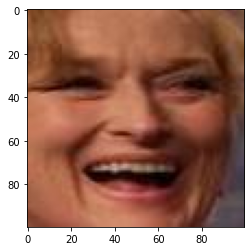

In [4]:
img_size = (100,100,3)

image = np.array(load_img(img_path, target_size=img_size))
plt.imshow(image)

# Model

In [5]:
model = load_model(input_model)
#print([layer.name for layer in model.layers])

pred_img = load_img(img_path, target_size = img_size[:2])
img_tensor = img_to_array(pred_img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.

classification_result = np.argmax(model.predict(img_tensor)[0])


2022-01-24 08:31:26.256856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-24 08:31:26.256942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-01-24 08:31:26.511741: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-24 08:31:26.559927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [6]:
last_conv_layer_name = 'conv2d_7'
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ['batch_normalization_7', 'max_pooling2d_2', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1']:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [7]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

gradcam = np.mean(last_conv_layer_output, axis=-1)
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, img_size[:2])

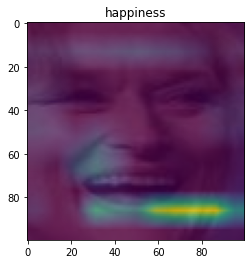

In [8]:
plt.title(labels_raf[classification_result] if input_model==model_raf else labels_fer[classification_result])
plt.imshow(image)
plt.imshow(gradcam, alpha=0.7)